**Aim:** 

# Differential analysis 

> Many methods have been used to determine differential gene expression from single-cell RNA (scRNA)-seq data. 

> Prefiltering of lowly expressed genes has important effects, particularly for some of the methods developed for bulk RNA-seq data analysis. However, we found that bulk RNA-seq analysis methods do not generally perform worse than those developed specifically for scRNA-seq. 

Source: [Soneson, C., Robinson, M. Bias, **robustness and scalability in single-cell differential expression analysis.** Nat Methods 15, 255–261 (2018).](https://doi.org/10.1038/nmeth.4612)

Also see 
[Wang, T., Li, B., Nelson, C.E. et al. **Comparative analysis of differential gene expression analysis tools for single-cell RNA sequencing data.** BMC Bioinformatics 20, 40 (2019).](https://doi.org/10.1186/s12859-019-2599-6)


[course chapter 12: Differential Expression (DE) analysis](https://biocellgen-public.svi.edu.au/mig_2019_scrnaseq-workshop/public/dechapter.html)


I'm also discussing this topic here https://github.com/abearab/sc-haircut-net/issues/3#issuecomment-832263091

## workflow
<img src="https://hbctraining.github.io/scRNA-seq/img/de_workflow_salmon.png" width="250" align="center"/>




<!-- https://github.com/theislab/diffxpy

https://diffxpy.readthedocs.io/en/latest/tutorials.html

https://nbviewer.jupyter.org/github/theislab/diffxpy_tutorials/blob/master/diffxpy_tutorials/test/introduction_differential_testing.ipynb

https://github.com/markrobinsonuzh/conquer

https://hbctraining.github.io/scRNA-seq/lessons/pseudobulk_DESeq2_scrnaseq.html

-->

### `DESeq2` 
<img src="https://hbctraining.github.io/scRNA-seq/img/de_workflow_salmon_deseq1.png" width="350" align="center"/>

> ### Estimate dispersion and DE using `DESeq2`
> Van den Berge and Perraudeau and others have shown the LRT may perform better for null hypothesis testing, so we use the LRT. In order to use the Wald test, it is recommended to set `useT=TRUE`.

> ### Plot dispersion estimates
> It is recommended to plot the dispersion estimates for DESeq2 on single-cell data. As discussed in the DESeq2 paper, it becomes difficult to accurately estimate the dispersion when the counts are very small, because the Poisson component of the variance is dominant. Therefore we see some very low dispersion estimates here, although the trend is still accurately capturing the upper proportion. So here everything looks good.


> If the parametric trend fails to fit (there would be a warning in this case), one should check the dispersion plot as above. If it looks like the dispersion fit is being thrown off by the low count genes with low dispersion estimates at the bottom of the plot, there is a relatively easy solution: one can filter out more of the low count genes only for the dispersion estimation step, so that the trend still captures the upper portion. This is pretty easy to do in DESeq2, to filter genes solely for the dispersion trend estimation, but to use a larger set for the rest of the analysis. An example of how this can be done:


In [ ]:
# %reload_ext rpy2.ipython

In [1]:
# # %%R 
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(purrr))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(DESeq2))
suppressPackageStartupMessages(library(edgeR))
suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(patchwork))
# suppressPackageStartupMessages(library(BiocParallel))
suppressPackageStartupMessages(library(SingleCellExperiment))

# multicoreParam <- MulticoreParam(workers = 2)
# register(multicoreParam)
# http://bioconductor.riken.jp/packages/2.14/bioc/vignettes/BiocParallel/inst/doc/Overview.pdf

In [2]:
# # %%R 
# makeDESeq <- function (counts,colData,design){
#     ### make DESeqDataSet object
#     dds <- DESeqDataSetFromMatrix(
#         countData = counts,
#         colData = colData,
#         design = design
#     )
#     return (dds)
# }

sce_prep <- function (counts,meta){
    ### Load data as `SingleCellExperiment` object 
    sce <- SingleCellExperiment(list(counts=counts),colData=meta)
    
    # ## low count filter - at least 10 cells with count of 5 or more
    # keep <- rowSums(counts(sce) >= 1) >= 10 
    # sce <- sce[keep,] 
    
    assay(sce) <- as.matrix(assay(sce))

    return (sce)
}


plot_Volcano <- function(res, lfc.cutoff  = 1,pval.cutoff = 0.05, title='', x_min=-20,x_max=20, y_max=FALSE){
    res$sig <- as.factor(res$pvalue < pval.cutoff & abs(res$log2FoldChange) > lfc.cutoff)
    relevel(res$sig, ref=TRUE)
    res <- res %>% mutate(name=rownames(res))
    
    data = subset(res[order(res$pvalue),], sig == TRUE)[1:7,]
    
    if (y_max == FALSE){-log10(min(res$pvalue))}
    
    vol = res %>% ggplot(
        aes(x=log2FoldChange, y=-log10(pvalue), colour=sig, fill=sig)) +
        geom_point(aes(color = sig),alpha = 1/10) +
            geom_hline(yintercept=-log10(pval.cutoff), linetype="dashed", alpha = 4/10) +
            geom_vline(xintercept=lfc.cutoff, linetype="dashed", alpha = 4/10) +
            geom_vline(xintercept=(-1)*lfc.cutoff, linetype="dashed", alpha = 4/10) +
            scale_color_manual(values = c("grey", "red")) +
            theme_bw() + 
            theme(
                legend.position="none",plot.title = element_text(hjust = 0.5)
            ) +
            ggtitle (title) + 
            ggrepel::geom_text_repel(
                data = data,
                aes(label = rownames(data)),
                size = 3,
                box.padding = unit(0.35, "lines"),
                point.padding = unit(0.3, "lines")
            ) + 
            xlim(c(x_min,x_max)) +
            if (y_max != FALSE){ylim(c(0,y_max))}

     return (vol)
} 

plotDisp <- function(dds){
    p1 = plotDispEsts(dds)
    keep <- rowSums(counts(dds) >= 10) >= 25
    dds2 <- estimateDispersionsFit(dds[keepForDispTrend,])
    p2 = plotDispEsts(dds2, ylim=c(1e-3,1))
}

plot_PCA <- function(vsd, gr, title,legend="none"){
    colData <- colData(vsd)
    z <- plotPCA(vsd,intgroup=gr, returnData=TRUE)
    percentVar <- round(100 * attr(z, "percentVar"))
    pca <- ggplot(z, aes(PC1, PC2)) + 
            geom_point(aes(size = 0.01, colour=group,fill=group), alpha = 0.1,shape=18) +
            xlab(paste0("PC1: ",percentVar[1],"% variance")) +
            ylab(paste0("PC2: ",percentVar[2],"% variance")) +
            guides (size = FALSE) +
            ggtitle (title)+ 
            theme(legend.position=legend)
    return (pca)
}

correct_batch <- function (dds,gr,out){
    vsd <- varianceStabilizingTransformation(dds, blind=FALSE)
    p0 <- plot_PCA(vsd, gr, 'Before removeBatchEffect')
    mat <- assay(vsd)
    
    mat <- limma::removeBatchEffect(mat, vsd$batch) 
    assay(vsd) <- mat
    p1 <- plot_PCA(vsd, gr, 'After removeBatchEffect',legend="right")
    counts_batch_corrected <- assay(vsd)
    
    if (out == 'plot'){return (p0 + p1)}
    if (out == 'vsd') {return (vsd)}
    if (out == 'cbc') {return (counts_batch_corrected)}
} 

# Comparisons 

In [ ]:
get_res<- function(fit,coef){
    fc <- fit[,coef]$coef [,coef] %>% data.frame 
    fc <- fc %>% dplyr::rename(log2FoldChange=colnames(fc))
    pv <- fit[,coef]$p.value [,coef] %>% data.frame 
    pv <- pv %>% dplyr::rename(pvalue=colnames(pv))
    res <- cbind(fc, pv)
    return(res)
}

> Note that the other data frames stored within the DGEList-object that contain gene- and sample-level information, are retained in the EList-object v created by voom. The `v$genes` data frame is equivalent to `x$genes`, `v$targets` is equivalent to `x$samples`, and the expression values stored in `v$E` is analogous to `x$counts`, albeit on a transformed scale. In addition to this, the voom EList-object has a matrix of precision weights `v$weights` and stores the design matrix in `v$design`.

## Epcam+ cells 
- {NSG,Nuj,Rag} vs Balb
- {NSG,Nuj} vs Rag

In [3]:
# import scanpy as sc

# Epcam_p = sc.read_h5ad('preprocessing/Epcam_p.h5ad.gz')

# counts = Epcam_p.to_df().T
# meta = Epcam_p.obs

In [4]:
# counts.to_csv('preprocessing/Epcam_p_counts.txt',sep='\t')

# meta.to_csv('preprocessing/Epcam_p_meta.txt',sep='\t')

Read inputs into `R`

In [117]:
# %%R
counts <- fread('deseq/Epcam_p_counts.txt',sep='\t') %>% 
    data.frame %>% column_to_rownames('V1') #%>% as.matrix
# %>% mutate_all(function(x) as.numeric(as.character(x)))

meta <- fread('deseq/Epcam_p_meta.txt',sep='\t') %>% 
    data.frame %>% column_to_rownames('V1')

meta <- meta %>% 
    mutate(rep = readr::parse_number(as.character(batch))) %>% 
    mutate(cond = as.character (gsub('[[:digit:]]+', '', as.character(batch))) )

rownames(meta) <- colnames(counts) 

meta$rep = factor(meta$rep)

meta$cond <- factor (meta$cond)
meta$cond <- relevel(meta$cond, ref="Balb")

conds <- meta$cond 
reps  <- meta$rep

Make <!-- `DESeq` -->object:

In [118]:
sc <- sce_prep(counts,meta)

In [119]:
de <- convertTo(sc, type="edgeR")

In [120]:
class(de)

[1] "DGEList"
attr(,"package")
[1] "edgeR"

- https://bioconductor.org/packages/release/workflows/vignettes/RNAseq123/inst/doc/limmaWorkflow.html
- https://bioconductor.org/packages/release/bioc/vignettes/scran/inst/doc/scran.html

In [121]:
design <- model.matrix(~0 + conds + reps )
colnames(design) <- gsub("conds", "", colnames(design))

contr.matrix <- makeContrasts(
    NSGvsBalb= NSG-Balb, 
    NujvsBalb= Nuj-Balb, 
    RagvsBalb= Rag-Balb, 
    NSGvsRag = NSG-Rag, 
    NujvsRag = Nuj-Rag, 
    levels = colnames(design)
)

contr.matrix

,NSGvsBalb,NujvsBalb,RagvsBalb,NSGvsRag,NujvsRag
Balb,-1,-1,-1,0,0
NSG,1,0,0,1,0
Nuj,0,1,0,0,1
Rag,0,0,1,-1,-1
reps2,0,0,0,0,0


In [122]:
# de2 <- de

# par(mfrow=c(1,2))
# lcpm <- cpm(de2, log=TRUE)
# boxplot(lcpm, las=2, col=col, main="")
# title(main="A. Example: Unnormalised data",ylab="Log-cpm")
# de2 <- calcNormFactors(de2)  
# de2$samples$norm.factors

# lcpm <- cpm(de2, log=TRUE)
# boxplot(lcpm, las=2, col=col, main="")
# title(main="B. Example: Normalised data",ylab="Log-cpm")

In [123]:
# par(mfrow=c(1,2))
# col.group <- group
# levels(col.group) <-  brewer.pal(nlevels(col.group), "Set1")
# col.group <- as.character(col.group)
# col.lane <- lane
# levels(col.lane) <-  brewer.pal(nlevels(col.lane), "Set2")
# col.lane <- as.character(col.lane)

# plotMDS(lcpm, labels=group, col=col.group)
# title(main="A. Sample groups")
# plotMDS(lcpm, labels=lane, col=col.lane, dim=c(3,4))
# title(main="B. Sequencing lanes")

In [124]:
# v <- voom(de, design, plot=FALSE)

# vfit <- lmFit(v, design)
# vfit <- contrasts.fit(vfit, contrasts=contr.matrix)
# efit <- eBayes(vfit)
# # plotSA(efit, main="Final model: Mean-variance trend")

In [125]:
# res_NSGvsBalb <- get_res(efit,'NSGvsBalb')
# res_NujvsBalb <- get_res(efit,'NujvsBalb')
# res_RagvsBalb <- get_res(efit,'RagvsBalb')
# res_NSGvsRag  <- get_res(efit,'NSGvsRag')
# res_NujvsRag  <- get_res(efit,'NujvsRag')

In [126]:
# res_NSGvsBalb %>% 
# plot_Volcano(
#     y_max=300,x_min=-2, x_max=2,lfc.cutoff  = 0.1,
#     title='NSGvsBalb'
# ) /
# res_NujvsBalb %>% 
# plot_Volcano(
#     y_max=300,x_min=-2, x_max=2,lfc.cutoff  = 0.1,
#     title='NujvsBalb'
# ) /
# res_RagvsBalb %>% plot_Volcano(
#     y_max=300,x_min=-2, x_max=2,lfc.cutoff  = 0.1,
#     title='RagvsBalb'
# ) 

In [127]:
# res_NSGvsRag  %>% plot_Volcano(
#     y_max=200,x_min=-2, x_max=2,lfc.cutoff  = 0.1,
#     title='NSGvsBalb'
# ) /
# res_NujvsRag  %>% plot_Volcano(
#     y_max=200,x_min=-2, x_max=2,lfc.cutoff  = 0.1,
#     title='res_NujvsRag'
# ) 

### normalize ?!

In [128]:
# Log tranform & Quantile normalize
de2 <- normalizeBetweenArrays(log(de$counts + 0.001))

In [129]:
vfit2 <- lmFit(de2, design)
vfit2 <- contrasts.fit(vfit2, contrasts=contr.matrix)
efit2 <- eBayes(vfit2)
# plotSA(efit, main="Final model: Mean-variance trend")

In [93]:
res_NSGvsBalb2 <- get_res(efit2,'NSGvsBalb')
write.table(
    res_NSGvsBalb2,
    'deseq/Epcam_p/delta_exp_NSG_vs_Balb.txt',
    sep='\t', quote=FALSE, col.names=TRUE, row.names=TRUE
)

res_NujvsBalb2 <- get_res(efit2,'NujvsBalb')
write.table(
    res_NujvsBalb2,
    'deseq/Epcam_p/delta_exp_Nuj_vs_Balb.txt',
    sep='\t', quote=FALSE, col.names=TRUE, row.names=TRUE
)

res_RagvsBalb2 <- get_res(efit2,'RagvsBalb')
write.table(
    res_RagvsBalb2,
    'deseq/Epcam_p/delta_exp_Rag_vs_Balb.txt',
    sep='\t', quote=FALSE, col.names=TRUE, row.names=TRUE
)

res_NSGvsRag2  <- get_res(efit2,'NSGvsRag')
write.table(
    res_NSGvsRag2,
    'deseq/Epcam_p/delta_exp_NSG_vs_Rag.txt',
    sep='\t', quote=FALSE, col.names=TRUE, row.names=TRUE
)

res_NujvsRag2  <- get_res(efit2,'NujvsRag')
write.table(
    res_NujvsRag2,
    'deseq/Epcam_p/delta_exp_Nuj_vs_Rag.txt',
    sep='\t', quote=FALSE, col.names=TRUE, row.names=TRUE
)

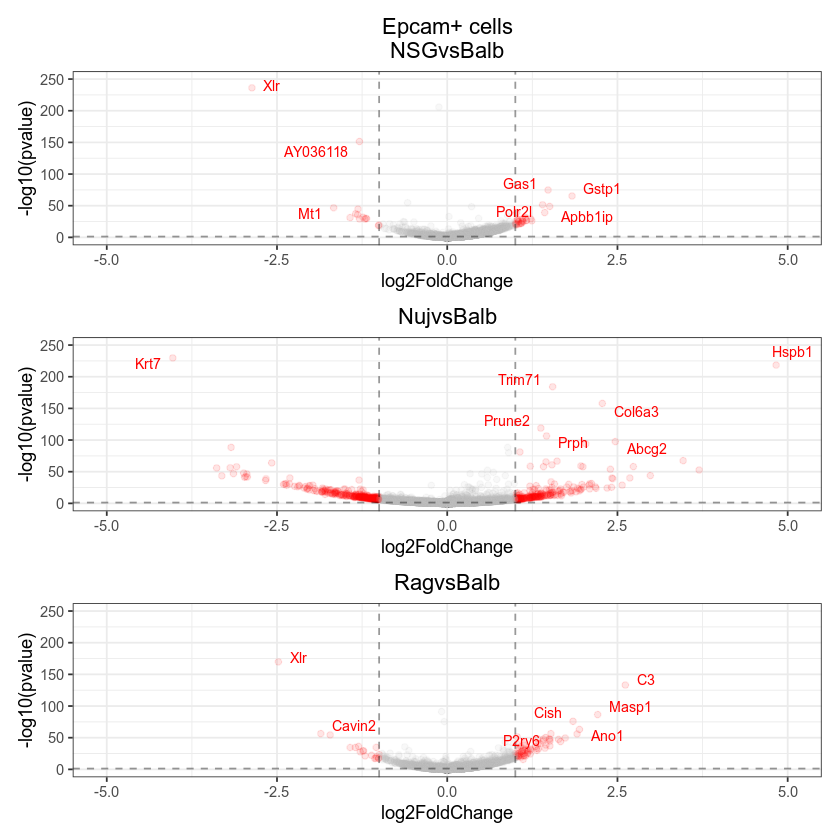

In [97]:
y_max=250
x=5

p1 <- res_NSGvsBalb2 %>% plot_Volcano(
    y_max=y_max,
    x_min=-1*x, x_max=x,
    # lfc.cutoff  = 0.1,
    title='Epcam+ cells\nNSGvsBalb'
) /
res_NujvsBalb2 %>% plot_Volcano(
    y_max=y_max,
    x_min=-1*x, x_max=x,
    # lfc.cutoff  = 0.1,
    title='NujvsBalb'
) /
res_RagvsBalb2 %>% plot_Volcano(
    y_max=y_max,
    x_min=-1*x, x_max=x,
    # lfc.cutoff  = 0.1,
    title='RagvsBalb'
) 

p1

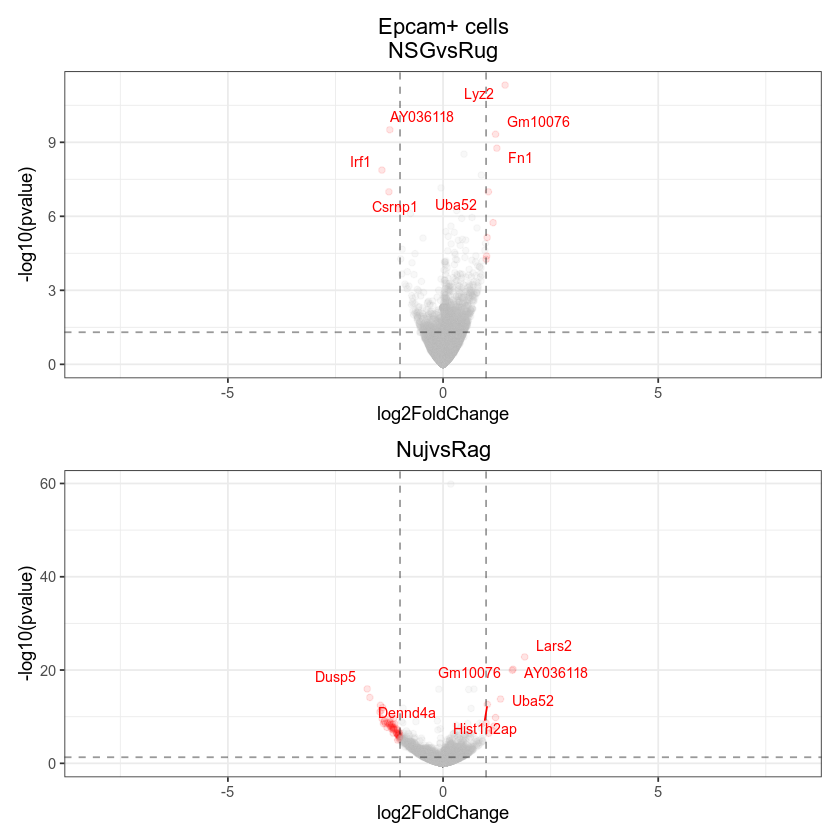

In [130]:
y_max=250
x=8

p2 <- res_NSGvsRag2  %>% plot_Volcano(
    # y_max=y_max,
    x_min=-1*x, x_max=x,
    # lfc.cutoff  = 0.1,
    title='Epcam+ cells\nNSGvsRug'
) /
res_NujvsRag2  %>% plot_Volcano(
    # y_max=y_max,
    x_min=-1*x, x_max=x,
    # lfc.cutoff  = 0.1,
    title='NujvsRag'
) 
p2

In [102]:
ggsave('deseq/Epcam_p/volcano_1.pdf',p1)

Saving 6.67 x 6.67 in image



In [131]:
ggsave('deseq/Epcam_p/volcano_2.pdf',p2)

Saving 6.67 x 6.67 in image



In [54]:
# # %%R 
# ## make DESeqDataSet object
# dds = makeDESeq(
#     round(counts), # https://support.bioconductor.org/p/133326/#133328
#     meta %>% select(cond,rep,batch),
#     ~cond + rep
# )

In [55]:
# keep <- rowSums(counts(dds) >= 1) >= 1
# dds <- dds[keep,]
# ### Estimate size factors
# dds <- estimateSizeFactors(dds, type="poscounts")
# scr <- scran::computeSumFactors(dds)
# # use scran's sum factors:
# sizeFactors(dds) <- sizeFactors(scr)

In [56]:
# !mkdir -p deseq/Epcam_p

In [57]:
# # %%R 
# saveRDS(dds, 'deseq/Epcam_p/dds_raw.rds')

In [58]:
# # %%R 
# dds_Balb <- dds
# dds_Balb$cond <- relevel(dds_Balb$cond, ref="Balb")

# ### Run DESeq Test (Annova like test ?)
# dds_Balb <- DESeq(
#     dds_Balb, test="LRT", reduced=~1,
#     minmu=1e-6, minRep=Inf #, parallel=FALSE#,BPPARAM=multicoreParam
# ) 

# print (resultsNames(dds_Balb))

In [59]:
# # %%R 
# dds_Balb <- dds
# dds_Balb$cond <- relevel(dds_Balb$cond, ref="Balb")

# ### Run DESeq Test (Annova like test ?)
# dds_Balb <- DESeq(
#     dds_Balb, test="LRT", reduced=~1,
#     minmu=1e-6, minRep=Inf #, parallel=TRUE,BPPARAM=multicoreParam
# ) 

# print (resultsNames(dds_Balb))

In [60]:
# # %%R 
# saveRDS(dds_Balb,'deseq/Epcam_p/dds_Balb_ref.rds')

In [291]:
# # %%R 
# saveRDS(dds_Balb,'deseq/Epcam_p/dds_Balb_ref.rds')

In [292]:
# # %%R 
# dds_Rag <- dds
# dds_Rag$cond <- relevel(dds_Rag$cond, ref="Rag")

# ### Run DESeq Test (Annova like test ?)
# dds_Rag <- DESeq(
#     dds_Rag, test="LRT", reduced=~1,
#     minmu=1e-6, minRep=Inf #, parallel=TRUE,BPPARAM=multicoreParam
# ) 

# print (resultsNames(dds_Rag))

In [295]:
# # %%R 
# saveRDS(dds_Balb,'deseq/Epcam_p/dds_Balb_ref.rds')

In [296]:
# # %%R 
# saveRDS(dds,'deseq/Epcam_p/dds_Balb_ref.rds')

In [298]:
# %timeit 
# # %%R -o ncu
# # cbc,
# # cbc <- correct_batch(dds_all,c('time'),'cbc') %>% data.frame
# ncu <- counts(dds, normalized=TRUE) %>% data.frame

In [299]:
# # Save normalized counts
# ncu.to_csv('deseq/Epcam_p/counts_normalized.txt.gz', compression='gzip')

In [ ]:
# cbc.to_csv('deseq/counts_batch_corrected.txt.gz', compression='gzip')

In [ ]:
# # %%R 
# dds <- estimateDispersionsGeneEst(dds)
# plotDisp(dds)

### PCA - removeBatchEffect

In [4]:
# %%R 
# dds <- readRDS('deseq/Epcam_p/dds.rds')

In [300]:
# %%R 
# correct_batch(dds,c('cond'),'plot') / correct_batch(dds,c('rep'),'plot')

Replace counts with correct counts after removing batch effect:

In [189]:
# # %%R 
# assay(dds_rG) <- correct_batch(dds_rG,'time','cbc') 

In [ ]:
# %%R 
# resultsNames(dds)

In [9]:
# # %%R -o NSG,Nuj,Rag

# NSG <- results(dds, name="cond_NSG_vs_Balb", independentFiltering=FALSE)  %>% 
#     data.frame %>% 
#     relocate(log2FoldChange)

# Nuj <- results(dds, name="cond_Nuj_vs_Balb", independentFiltering=FALSE)  %>% 
#     data.frame %>% 
#     relocate(log2FoldChange)


# Rag <- results(dds, name="cond_Rag_vs_Balb", independentFiltering=FALSE)  %>% 
#     data.frame %>% 
#     relocate(log2FoldChange)

In [304]:
# NSG.to_csv('deseq/Epcam_p/delta_exp_NSG_vs_Balb.txt',sep='\t')
# Nuj.to_csv('deseq/Epcam_p/delta_exp_Nuj_vs_Balb.txt',sep='\t')
# Rag.to_csv('deseq/Epcam_p/delta_exp_Rag_vs_Balb.txt',sep='\t')

In [253]:
# # %%R 
# g1 <- plot_Volcano(NSG,y_max=300,x_min=-15, x_max=15,title='NSG_vs_Balb')
# g2 <- plot_Volcano(Nuj,y_max=300,x_min=-15, x_max=15,title='Nuj_vs_Balb')
# g3 <- plot_Volcano(Rag,y_max=300,x_min=-15, x_max=15,title='Rag_vs_Balb')

In [252]:
# # %%R 
# g = g1 / g2 / g3
# g

In [305]:
# %%R 
# ggsave('deseq/Epcam_p/volcano.pdf',g)

Plot counts

In [306]:
# %%R 
# dds <- readRDS('deseq/Epcam_p/dds.rds') 

In [307]:
# %%R 
# Save plotcounts to a data frame object
# d1 <- plotCounts(dds, gene="Xlr", intgroup=c('cond','rep'), returnData=TRUE)
# d2 <- plotCounts(dds, gene="C3", intgroup=c('cond','rep'), returnData=TRUE)

In [308]:
# %%R 
# p1 <- ggplot(d1, aes(x = cond, y = count, color = rep)) +
#   geom_violin() +
#   ggtitle("Xlr") + 
#   coord_flip() +
#   theme_bw() +
#   theme(legend.position="none") +
#   theme(plot.title = element_text(hjust = 0.5)) + 
#   scale_y_log10()

# p2 <- ggplot(d2, aes(x = cond, y = count, color = rep)) +
#   geom_violin() +
#   ggtitle("C3") + 
#   coord_flip() +
#   theme_bw() +
#   theme(plot.title = element_text(hjust = 0.5)) + 
#   scale_y_log10()

# p1+p2

In [309]:
# %%R 
# ggsave('deseq/Epcam_p/plot_counts.pdf',p1+p2)

## T cells
- {NSG,Nuj,Rag} vs Balb
- {NSG,Nuj} vs Rag

In [134]:
# import scanpy as sc

# T_cells = sc.read_h5ad('preprocessing/T_cells.h5ad.gz')

# counts = T_cells.to_df().T
# meta = T_cells.obs

In [135]:
# mkdir -p deseq/T_cells

In [136]:
# counts.to_csv('deseq/T_cells_counts.txt',sep='\t')

# meta.to_csv('deseq/T_cells_meta.txt',sep='\t')

___

Read inputs into `R`

In [137]:
# %%R
counts <- fread('deseq/T_cells_counts.txt',sep='\t') %>% 
    data.frame %>% column_to_rownames('V1') #%>% as.matrix
# %>% mutate_all(function(x) as.numeric(as.character(x)))

meta <- fread('deseq/T_cells_meta.txt',sep='\t') %>% 
    data.frame %>% column_to_rownames('V1')

meta <- meta %>% 
    mutate(rep = readr::parse_number(as.character(batch))) %>% 
    mutate(cond = as.character (gsub('[[:digit:]]+', '', as.character(batch))) )

rownames(meta) <- colnames(counts) 

meta$rep = factor(meta$rep)

meta$cond <- factor (meta$cond)
meta$cond <- relevel(meta$cond, ref="Balb")

conds <- meta$cond 
reps  <- meta$rep

Make <!-- `DESeq` -->object:

In [138]:
sc <- sce_prep(counts,meta)

In [139]:
de <- convertTo(sc, type="edgeR")

In [140]:
class(de)

[1] "DGEList"
attr(,"package")
[1] "edgeR"

- https://bioconductor.org/packages/release/workflows/vignettes/RNAseq123/inst/doc/limmaWorkflow.html
- https://bioconductor.org/packages/release/bioc/vignettes/scran/inst/doc/scran.html

In [141]:
design <- model.matrix(~0 + conds + reps )
colnames(design) <- gsub("conds", "", colnames(design))

contr.matrix <- makeContrasts(
    NSGvsBalb= NSG-Balb, 
    NujvsBalb= Nuj-Balb, 
    RagvsBalb= Rag-Balb, 
    NSGvsRag = NSG-Rag, 
    NujvsRag = Nuj-Rag, 
    levels = colnames(design)
)

contr.matrix

,NSGvsBalb,NujvsBalb,RagvsBalb,NSGvsRag,NujvsRag
Balb,-1,-1,-1,0,0
NSG,1,0,0,1,0
Nuj,0,1,0,0,1
Rag,0,0,1,-1,-1
reps2,0,0,0,0,0


In [142]:
# Log tranform & Quantile normalize
de2 <- normalizeBetweenArrays(log(de$counts + 0.001))

In [144]:
vfit2 <- lmFit(de2, design)
vfit2 <- contrasts.fit(vfit2, contrasts=contr.matrix)
efit2 <- eBayes(vfit2)
# plotSA(efit2, main="Final model: Mean-variance trend")

In [145]:
res_NSGvsBalb2 <- get_res(efit2,'NSGvsBalb')
write.table(
    res_NSGvsBalb2,
    'deseq/T_cells/delta_exp_NSG_vs_Balb.txt',
    sep='\t', quote=FALSE, col.names=TRUE, row.names=TRUE
)

res_NujvsBalb2 <- get_res(efit2,'NujvsBalb')
write.table(
    res_NujvsBalb2,
    'deseq/T_cells/delta_exp_Nuj_vs_Balb.txt',
    sep='\t', quote=FALSE, col.names=TRUE, row.names=TRUE
)

res_RagvsBalb2 <- get_res(efit2,'RagvsBalb')
write.table(
    res_RagvsBalb2,
    'deseq/T_cells/delta_exp_Rag_vs_Balb.txt',
    sep='\t', quote=FALSE, col.names=TRUE, row.names=TRUE
)

res_NSGvsRag2  <- get_res(efit2,'NSGvsRag')
write.table(
    res_NSGvsRag2,
    'deseq/T_cells/delta_exp_NSG_vs_Rag.txt',
    sep='\t', quote=FALSE, col.names=TRUE, row.names=TRUE
)

res_NujvsRag2  <- get_res(efit2,'NujvsRag')
write.table(
    res_NujvsRag2,
    'deseq/T_cells/delta_exp_Nuj_vs_Rag.txt',
    sep='\t', quote=FALSE, col.names=TRUE, row.names=TRUE
)

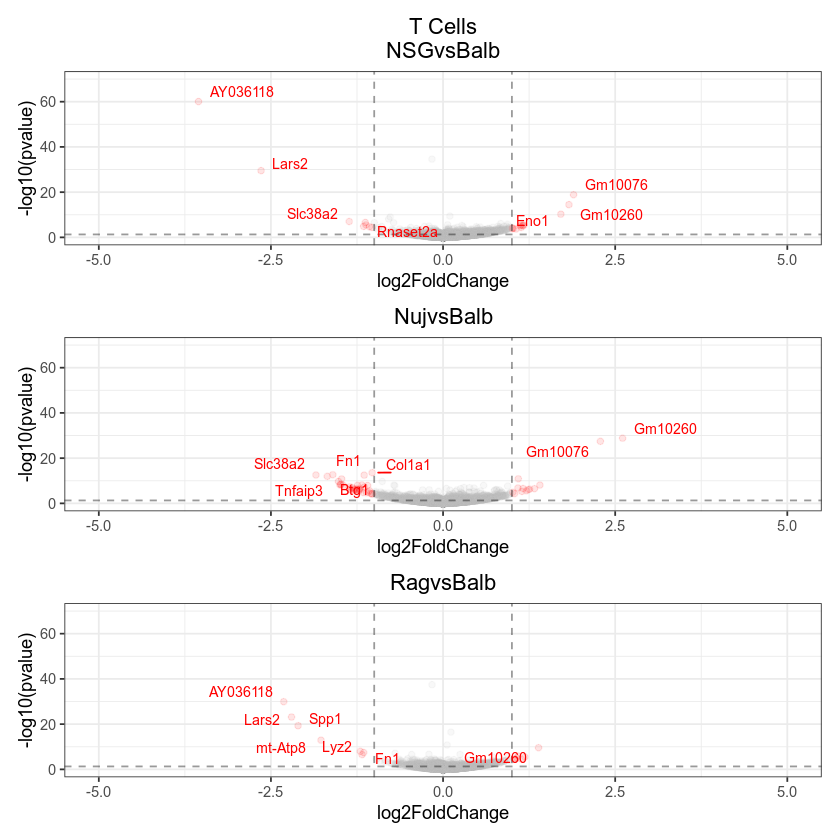

In [146]:
y_max=70
x=5

p1 <- res_NSGvsBalb2 %>% plot_Volcano(
    y_max=y_max,
    x_min=-1*x, x_max=x,
    # lfc.cutoff  = 0.1,
    title='T Cells\nNSGvsBalb'
) /
res_NujvsBalb2 %>% plot_Volcano(
    y_max=y_max,
    x_min=-1*x, x_max=x,
    # lfc.cutoff  = 0.1,
    title='NujvsBalb'
) /
res_RagvsBalb2 %>% plot_Volcano(
    y_max=y_max,
    x_min=-1*x, x_max=x,
    # lfc.cutoff  = 0.1,
    title='RagvsBalb'
) 
p1

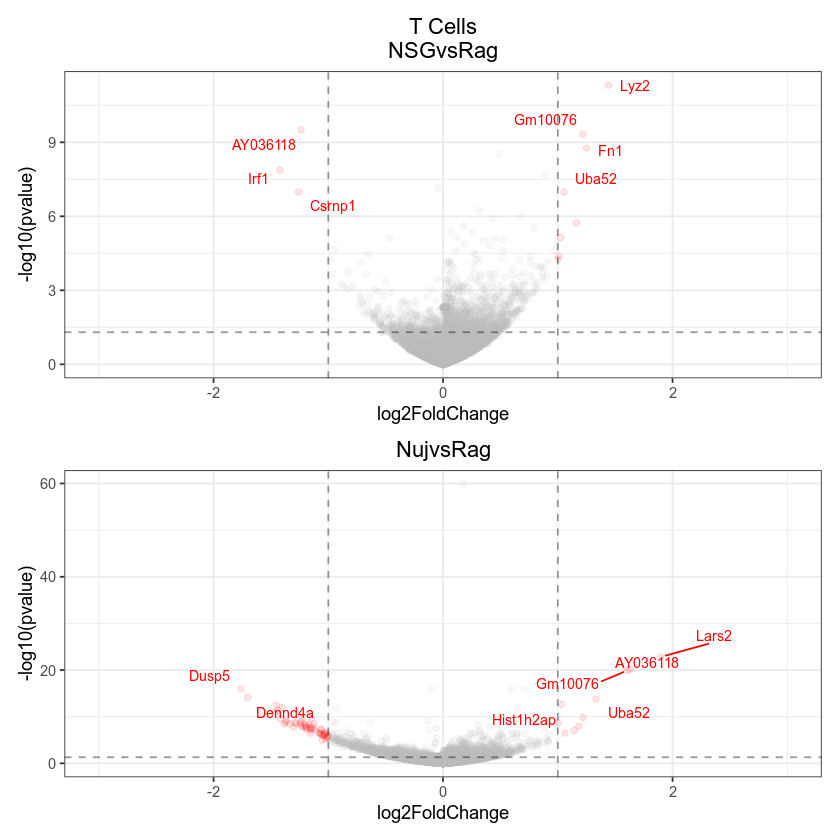

In [147]:
y_max=250
x=3

p2 <- res_NSGvsRag2  %>% plot_Volcano(
    # y_max=y_max,
    x_min=-1*x, x_max=x,
    # lfc.cutoff  = 0.1,
    title='T Cells\nNSGvsRag'
) /
res_NujvsRag2  %>% plot_Volcano(
    # y_max=y_max,
    x_min=-1*x, x_max=x,
    # lfc.cutoff  = 0.1,
    title='NujvsRag'
) 
p2

In [148]:
ggsave('deseq/T_cells/volcano_1.pdf',p1)

Saving 6.67 x 6.67 in image



In [149]:
ggsave('deseq/T_cells/volcano_2.pdf',p2)

Saving 6.67 x 6.67 in image



In [73]:
# %%R 
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.10

Matrix products: default
BLAS/LAPACK: /avicenna/abolfazl/anaconda3/envs/diff-analysis/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] patchwork_1.1.1             scran_1.22.0               
 [3] scuttle_1.4.0               SingleCellExperiment_1.16.0
 [5] edgeR_3.36.0                limma_3.50.0               
 [7] DESeq2_1.34.0               SummarizedExperiment_1.24.0
 [9] Biobase_2.54.0              MatrixG

# Pathway analysis

    nohup ls delta_exp*.txt | parallel -j8 -k bash /avicenna/abolfazl/Bahar/ipage_loop.sh {} &>> ipage.out &